# Load Data

In [1]:
#40 people were
from sklearn.datasets import fetch_olivetti_faces

data, target = fetch_olivetti_faces(random_state=42, return_X_y=True)


In [2]:
print(fetch_olivetti_faces(random_state=42).DESCR) # Data Description

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [3]:
print(data.shape)
print(target.shape)
print(len(target))
data

(400, 4096)
(400,)
400


array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

# Split into Training, Validation and Test Sets

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1,test_size= 40,  random_state=42)

for train_val_index, test_index in sss.split(data, target):
    X_train_val, y_train_val = data[train_val_index], target[train_val_index]
    X_test, y_test = data[test_index], target[test_index]
    
sss = StratifiedShuffleSplit(n_splits=1,test_size= 80,  random_state=24)
for train_index, val_index in sss.split(data, target):
    X_train, y_train = data[train_index], target[train_index]
    X_val, y_val = data[val_index], target[val_index]

In [5]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_val.shape)
print(y_val.shape)
print()
print(X_test.shape)
print(y_test.shape)

(320, 4096)
(320,)

(80, 4096)
(80,)

(40, 4096)
(40,)


# Before using KMeans, use PCA to reduce Dimensionality of the data to 95% variance

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train) #fit then transform the data for X_train
X_val_pca = pca.transform(X_val) #CAUTION: We just need to transform the data not fit the model to the validation
X_test_pca = pca.transform(X_test)


# Use KMeans 

In [7]:
from sklearn.cluster import KMeans

k_means_range = []

for k in range(5, 150, 5):
    km = KMeans(random_state=42, n_clusters= k, n_jobs=-1, n_init=15)
    k_means_range.append(km.fit(X_train_pca))

In [8]:
from sklearn.metrics import silhouette_score

silhouette_scores_list = []

for kmeans in k_means_range:
    silhouette_scores_list.append(silhouette_score(X_train_pca, kmeans.labels_))

In [9]:
len(silhouette_scores_list)

29

In [10]:
import numpy as np

#silhouette score with the highest value is the best model
best_index = np.argmax(silhouette_scores_list) #argmax returns the maximum value's index
best_k = k_means_range[best_index]
best_score = silhouette_scores_list[best_index]

print(best_score)
print(best_k)

0.2563812
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=135, n_init=15, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


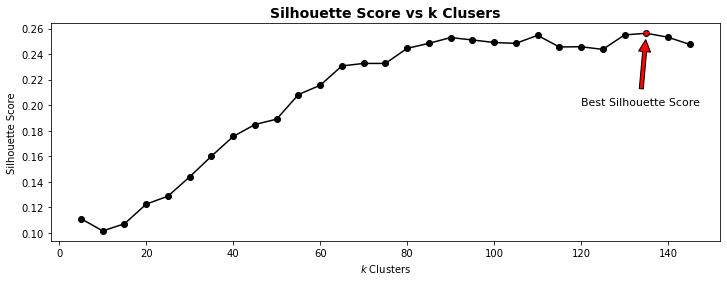

In [11]:
#plot silhouette diagram
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(range(5, 150, 5), silhouette_scores_list, 'ko-')
plt.title('Silhouette Score vs k Clusers', fontweight= 'bold', fontsize=14)
plt.xlabel('$k$ Clusters')
plt.ylabel('Silhouette Score')
plt.plot(best_k.n_clusters, best_score, 'r*')
plt.annotate('Best Silhouette Score', xytext= (120, 0.2), xy=(best_k.n_clusters, best_score), fontsize=11,
             arrowprops= dict(facecolor='red', shrink=0.1))
plt.show()

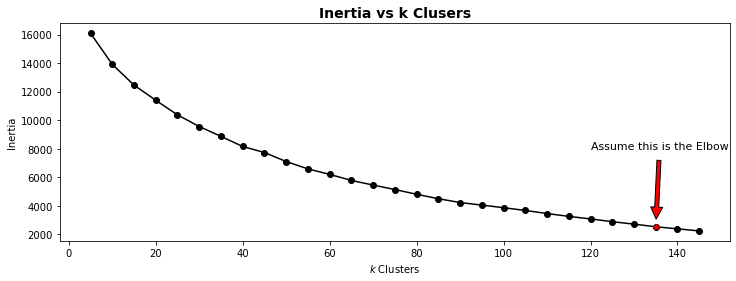

In [12]:
#plot inertia diagram

inertias = [km.inertia_ for km in k_means_range]

plt.figure(figsize=(12, 4))
plt.plot(range(5, 150, 5), inertias, 'ko-')
plt.title('Inertia vs k Clusers', fontweight= 'bold', fontsize=14)
plt.xlabel('$k$ Clusters')
plt.ylabel('Inertia')
plt.plot(best_k.n_clusters, best_k.inertia_, 'r*')
plt.annotate('Assume this is the Elbow', xytext= (120, 8000), xy=(best_k.n_clusters, best_k.inertia_), fontsize=11,
             arrowprops= dict(facecolor='red', shrink=0.1))
plt.show()

##### There is no obvious elbow so assume 135 clusters.

### See the clusters, we have to use plt.imshow
We have to reshape each picture from a 1D 4096 array to a 64 x 64 matrix and set cmap='gray'.

In [13]:
X_train[0].reshape(64, 64)

array([[0.44214877, 0.6280992 , 0.59090906, ..., 0.5       , 0.46280992,
        0.45041323],
       [0.49586776, 0.6570248 , 0.57438016, ..., 0.54545456, 0.45867768,
        0.43801653],
       [0.5495868 , 0.607438  , 0.57024795, ..., 0.553719  , 0.47107437,
        0.43801653],
       ...,
       [0.16115703, 0.14876033, 0.14876033, ..., 0.19008264, 0.10743801,
        0.08264463],
       [0.1570248 , 0.15289256, 0.14876033, ..., 0.15289256, 0.10743801,
        0.0785124 ],
       [0.16528925, 0.15289256, 0.16115703, ..., 0.11983471, 0.0785124 ,
        0.08677686]], dtype=float32)

Text(0.5, 1.0, '13')

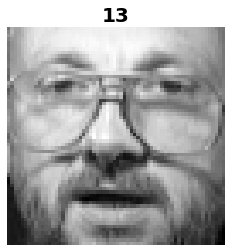

In [14]:
plt.imshow(X_train[0].reshape(64, 64), cmap='gray')
plt.axis('off')
plt.title(y_train[0], fontsize= 20, fontweight='bold')

Great! Try make this into a function so we do not have to repeat this for 400 faces!

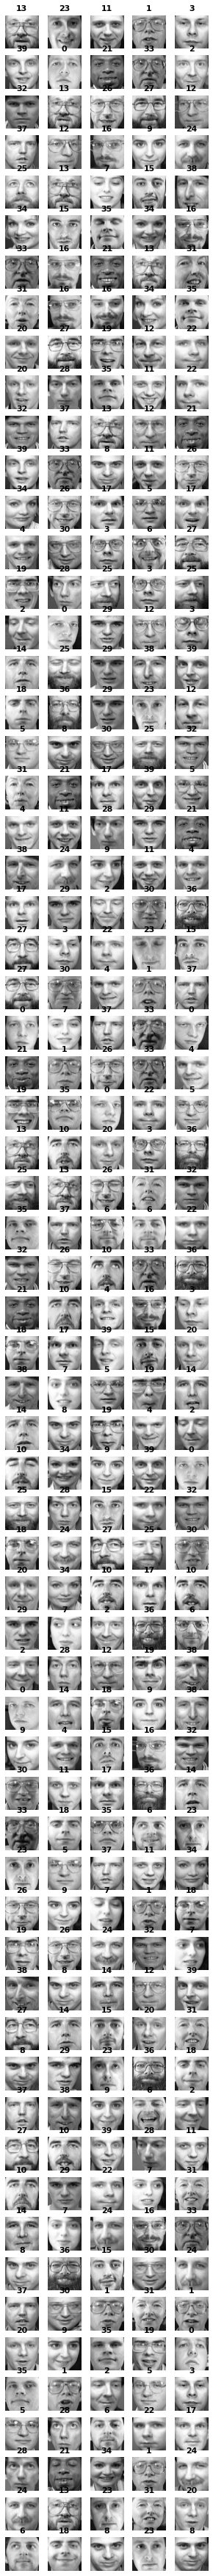

In [15]:
def plot_faces(faces, labels, n_cols=5):
    #find the number of rows required to plot all the faces
    n_rows = (len(faces) -1)// n_cols+1
    
    #plot figure the size of n_cols by n_rows
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index+1)
        
        #copy from above cell
        plt.imshow(face.reshape(64, 64), cmap='gray')
        plt.axis('off')
        plt.title(label, fontsize= 11, fontweight='bold')
    plt.show()

plot_faces(X_train, y_train)

In [16]:
np.unique(best_k.labels_)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134])

Cluster  0


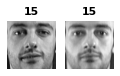

Cluster  1


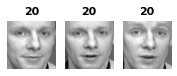

Cluster  2


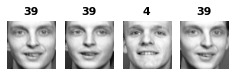

Cluster  3


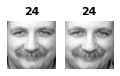

Cluster  4


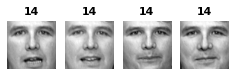

Cluster  5


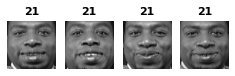

Cluster  6


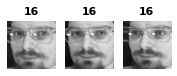

Cluster  7


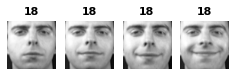

Cluster  8


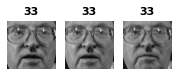

Cluster  9


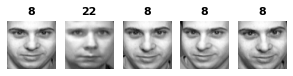

Cluster  10


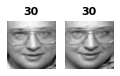

Cluster  11


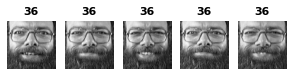

Cluster  12


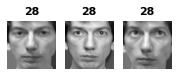

Cluster  13


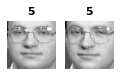

Cluster  14


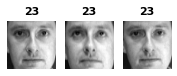

Cluster  15


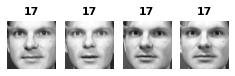

Cluster  16


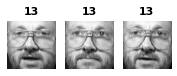

Cluster  17


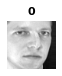

Cluster  18


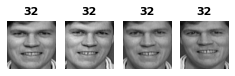

Cluster  19


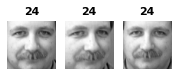

Cluster  20


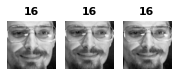

Cluster  21


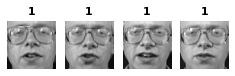

Cluster  22


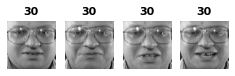

Cluster  23


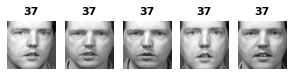

Cluster  24


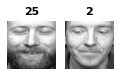

Cluster  25


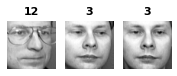

Cluster  26


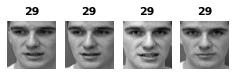

Cluster  27


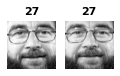

Cluster  28


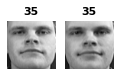

Cluster  29


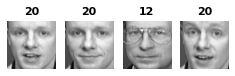

Cluster  30


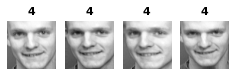

Cluster  31


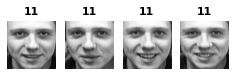

Cluster  32


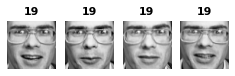

Cluster  33


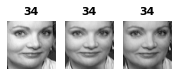

Cluster  34


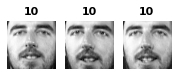

Cluster  35


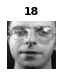

Cluster  36


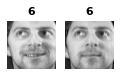

Cluster  37


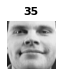

Cluster  38


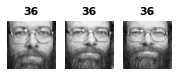

Cluster  39


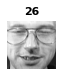

Cluster  40


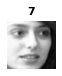

Cluster  41


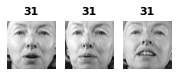

Cluster  42


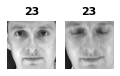

Cluster  43


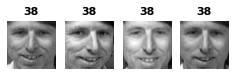

Cluster  44


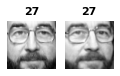

Cluster  45


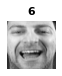

Cluster  46


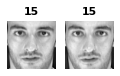

Cluster  47


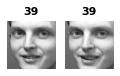

Cluster  48


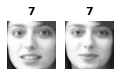

Cluster  49


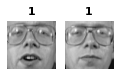

Cluster  50


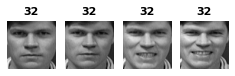

Cluster  51


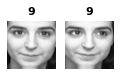

Cluster  52


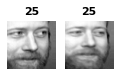

Cluster  53


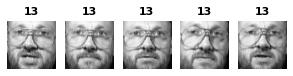

Cluster  54


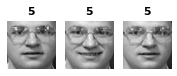

Cluster  55


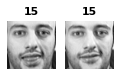

Cluster  56


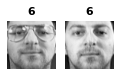

Cluster  57


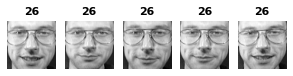

Cluster  58


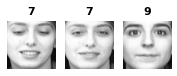

Cluster  59


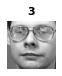

Cluster  60


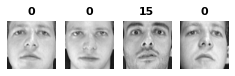

Cluster  61


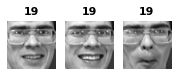

Cluster  62


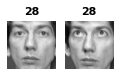

Cluster  63


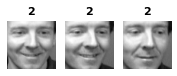

Cluster  64


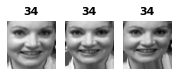

Cluster  65


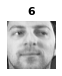

Cluster  66


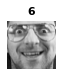

Cluster  67


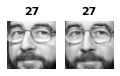

Cluster  68


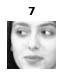

Cluster  69


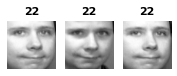

Cluster  70


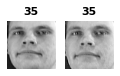

Cluster  71


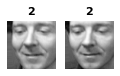

Cluster  72


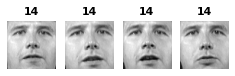

Cluster  73


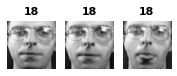

Cluster  74


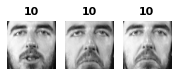

Cluster  75


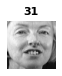

Cluster  76


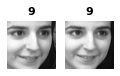

Cluster  77


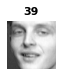

Cluster  78


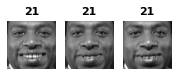

Cluster  79


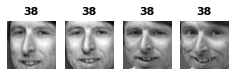

Cluster  80


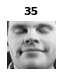

Cluster  81


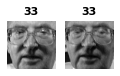

Cluster  82


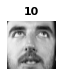

Cluster  83


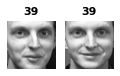

Cluster  84


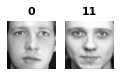

Cluster  85


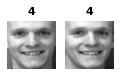

Cluster  86


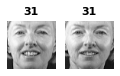

Cluster  87


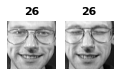

Cluster  88


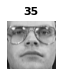

Cluster  89


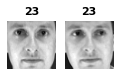

Cluster  90


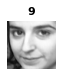

Cluster  91


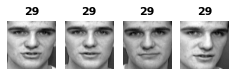

Cluster  92


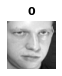

Cluster  93


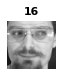

Cluster  94


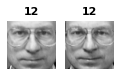

Cluster  95


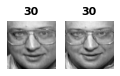

Cluster  96


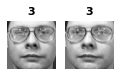

Cluster  97


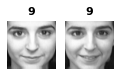

Cluster  98


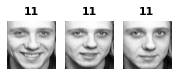

Cluster  99


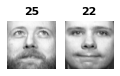

Cluster  100


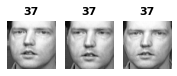

Cluster  101


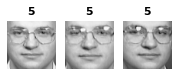

Cluster  102


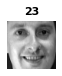

Cluster  103


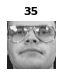

Cluster  104


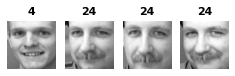

Cluster  105


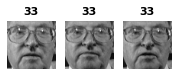

Cluster  106


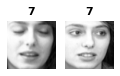

Cluster  107


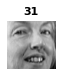

Cluster  108


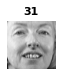

Cluster  109


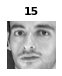

Cluster  110


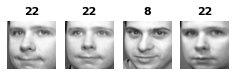

Cluster  111


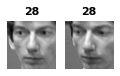

Cluster  112


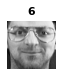

Cluster  113


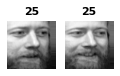

Cluster  114


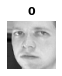

Cluster  115


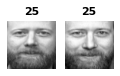

Cluster  116


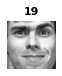

Cluster  117


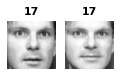

Cluster  118


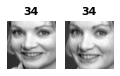

Cluster  119


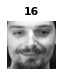

Cluster  120


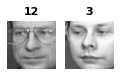

Cluster  121


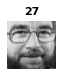

Cluster  122


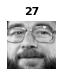

Cluster  123


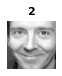

Cluster  124


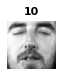

Cluster  125


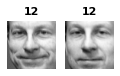

Cluster  126


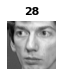

Cluster  127


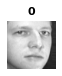

Cluster  128


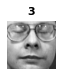

Cluster  129


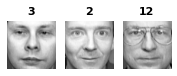

Cluster  130


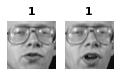

Cluster  131


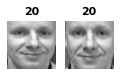

Cluster  132


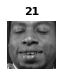

Cluster  133


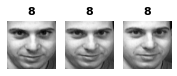

Cluster  134


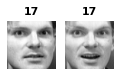

In [17]:
for cluster_id in np.unique(best_k.labels_):
    print('Cluster ', cluster_id)
    X_cluster = X_train[cluster_id == best_k.labels_]
    y_cluster = y_train[cluster_id == best_k.labels_]
    plot_faces(X_cluster, y_cluster)


In [18]:
# y_train ==1

# X_train[0].shape

## Some clusters only have 1 image, this is extremly inefficient. We should try to label some of these using Label Propagation.
### First let's train a model to see what the score is using the PCA data to speed up training

In [19]:
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=135)
rand_clf.fit(X_train_pca, y_train)

rand_clf.score(X_val_pca, y_val)

0.9625

## Find the best number of clusters using the PCA reduced data

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

kmeans = KMeans(random_state=42, n_jobs=-1, n_init=15)
rand_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe = Pipeline([
    ('Kmeans', kmeans),
    ('RandomForest', rand_clf)
])

params_grid = {'Kmeans__n_clusters' : range(100, 150, 10),
    'RandomForest__n_estimators' : range(100, 150, 10)}

grid_search = GridSearchCV(pipe, param_grid=params_grid, n_jobs=-1, cv=2)

grid_search.fit(X_train_pca, y_train)
grid_search.score(X_val_pca, y_val)

0.8375

In [21]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('Kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=120, n_init=15, n_jobs=-1,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('RandomForest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=140, n_job

####  ****MISTAKE! I should not have used GridSearch Cross Validation here! Since I already have a validation set to score the data against. Next time, a manual implementation of finding the best clusters, by using a for loop.  Revised value of cv from 5 to 2, the minimum value.  ****

Out of curisoity, train the original data using the Random Forest using the values from the Grid Search.

In [22]:
random_forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=140, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False)

random_forest.fit(X_train, y_train)

random_forest.score(X_val, y_val)

0.9625

#### WOW ! 96.25% without PCA. Makes me wonder why I even bothered with PCA, but I'm sure that good practice of using PCA with large multidimensional data sets will come in handy some day. 

In [23]:
## Playground Code :) 
# print(X_train_pca[0].shape)
# print(X_train[0].shape)
# np.c_[X_train, X_train_pca].shape

# X_train_pca.shape #320 rows x 111 columns


# X_train.shape #320 rows x 4096 columns

# np.c_[ [4,5,6, 4, 5,66 ], [[1],[2],[3]]] #colum vector and row vector combines to make a single matrix 

# #the np.c_ gives a matrix the 

# y =np.array([[1],[2],[3]])#.shape
# y

# x= np.array([[4,5,6], [2,3,4], [7,8,9]])#.shape #3 rows x 3 columns
# x

# np.c_[x, y]

### Using both the PCA reduced dataset and the KMean's best model to reduce the data's dimensionality even futher. Combine both the models using numpy.c_ along the column and see if the score increases.

<i>Note that the playground cell above shows what the np.c_ is doing here. c_ is concatenating along the column, assuming the rows stay the same! Which they are, i.e. the number of instances is not reducing, we are only reducing the 1D vector per instance. </i>

In [24]:
X_train_reduced = best_k.transform(X_train_pca)
X_val_reduced = best_k.transform(X_val_pca)
X_test_reduced = best_k.transform(X_test_pca)

In [25]:
#combine both the reduced data sets 
X_train_extended = np.c_[X_train_reduced, X_train_pca]
X_val_extended = np.c_[X_val_reduced, X_val_pca]
X_test_extended = np.c_[X_test_reduced, X_test_pca]

r_clf = RandomForestClassifier(random_state=42, n_estimators=150, n_jobs=-1)
r_clf.fit(X_train_extended, y_train)
r_clf.score(X_val_extended, y_val)

0.8875

### Great the has score increased, we have gained ~5%. 

## Train a Gaussian Mixture Model using PCA dataset preserving 99% of the variance. 